In [1]:
# import cv2
# import numpy as np

# def calculate_transmission_map(hazy_image, window_size=3, percentile=0.001, omega=0.99):
#     """Calculate the transmission map of a hazy image using the Dark Channel Prior method."""
    
#     def dark_channel(image):
#         """Calculate the dark channel of an image."""
#         min_channel = np.min(image, axis=2)
#         return cv2.erode(min_channel, np.ones((window_size, window_size), np.uint8))
    
#     def estimate_atmospheric_light(image, dark_channel):
#         """Estimate the atmospheric light of an image."""
#         flat_dark_channel = dark_channel.flatten()
#         num_pixels = flat_dark_channel.size
#         num_pixels_to_keep = int(num_pixels * percentile)
#         sorted_dark_channel = np.sort(flat_dark_channel)
#         atmospheric_light = np.mean(sorted_dark_channel[-num_pixels_to_keep:])
#         return atmospheric_light
    
#     def estimate_transmission(image, atmospheric_light):
#         """Estimate the transmission map of an image."""
#         normalized_image = image.astype(np.float32) / atmospheric_light
#         dark_ch = dark_channel(normalized_image)
#         transmission_map = 1-(omega * dark_ch)
#         return transmission_map

#     # Calculate the dark channel
#     dark_ch = dark_channel(hazy_image)

#     # Estimate the atmospheric light
#     atmospheric_light = estimate_atmospheric_light(hazy_image, dark_ch)

#     # Estimate the transmission map
#     transmission_map = estimate_transmission(hazy_image, atmospheric_light)

#     # Convert the transmission map to 3 channels
#     transmission_map_3ch = cv2.cvtColor(transmission_map, cv2.COLOR_GRAY2BGR)

#     return transmission_map_3ch

In [2]:
# import sys
# import cv2
# import numpy as np
# import tensorflow as tf
# import os
# from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
# from tensorflow.image import ssim
# from PyQt5.QtWidgets import QApplication, QMainWindow, QFileDialog, QPushButton, QVBoxLayout, QWidget, QLabel, QHBoxLayout
# from PyQt5.QtGui import QImage, QPixmap
# from PyQt5.QtCore import Qt
# import time
# import threading

# # Define your model and its architecture

# # Define loss calculation function
# def total_loss(y_true, y_pred):
#     lambda_mse = 2.5  # Adjust as needed
#     lambda_mae = 2.5
#     lambda_ssim = 18  # Adjust as needed
#     lambda_color = 20  # Adjust the weight as needed

#     # Compute MSE loss
#     mse = MeanSquaredError()(y_true, y_pred)

#     # Compute MAE loss
#     mae = MeanAbsoluteError()(y_true, y_pred)

#     # Compute SSIM loss
#     ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)  # max_val should match your image range (e.g., 0-1)

#     # Custom color loss based on color histograms
#     def color_loss(y_true, y_pred):
#         # Convert the images to grayscale
#         y_true_gray = tf.image.rgb_to_grayscale(y_true)
#         y_pred_gray = tf.image.rgb_to_grayscale(y_pred)

#         # Calculate the MSE between the grayscale images
#         color_loss = tf.reduce_mean(tf.square(y_true_gray - y_pred_gray))

#         return color_loss

#     # Compute color loss
#     color = color_loss(y_true, y_pred)

#     # Combine losses with weights
#     loss = (
#         lambda_mse * mse +
#         lambda_mae * mae +
#         lambda_ssim * ssim_loss +
#         lambda_color * color
#     )

#     return loss

# # Load the pre-trained dehazing model
# model = tf.keras.models.load_model(filepath='modelTwo.h5',custom_objects={'total_loss': total_loss})
# #model = tf.keras.models.load_model(filepath='model.h5')

# # Define a function to preprocess the frame
# def preprocess_frame(frame):
#     # Convert the frame to RGB
#     rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Resize the frame to (96, 124)
#     resized_frame = cv2.resize(rgb_frame, (512, 512))

#     # Normalize the frame
#     normalized_frame = resized_frame / 255.0

#     # Add an extra dimension for batch size
#     preprocessed_frame = np.expand_dims(normalized_frame, axis=0)

#     return preprocessed_frame

# # Define a function to postprocess the frame
# def postprocess_frame(frame, original_shape):
#     # Resize the frame to the original shape
#     resized_frame = cv2.resize(frame, (original_shape[1], original_shape[0]))

#     # Convert the frame to BGR
#     bgr_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2BGR)

#     # Convert the frame to uint8
#     final_frame = (bgr_frame * 255.0).astype(np.uint8)

#     return final_frame

# # Define the main window class
# class VideoProcessingApp(QMainWindow):
#     def __init__(self):
#         super().__init__()

#         self.setWindowTitle("Video Processing App")
#         self.setGeometry(100, 100, 1024, 768)

#         self.initUI()
#         self.video_processing_thread = None

#     def initUI(self):
#         self.central_widget = QWidget()
#         self.setCentralWidget(self.central_widget)

#         self.input_video_label = QLabel("Input Video:")
#         self.input_video_display = QLabel()
#         self.input_video_display.setAlignment(Qt.AlignCenter)

#         self.output_video_label = QLabel("Output Video:")
#         self.output_video_display = QLabel()
#         self.output_video_display.setAlignment(Qt.AlignCenter)

#         self.load_video_button = QPushButton("Load Video")
#         self.load_video_button.clicked.connect(self.load_video)

#         # Layout setup
#         layout = QVBoxLayout()
#         layout.addWidget(self.input_video_label)
#         layout.addWidget(self.input_video_display)
#         layout.addWidget(self.output_video_label)
#         layout.addWidget(self.output_video_display)
#         layout.addWidget(self.load_video_button)
#         self.central_widget.setLayout(layout)

#     def load_video(self):
#         options = QFileDialog.Options()
#         options |= QFileDialog.ReadOnly
#         file_name, _ = QFileDialog.getOpenFileName(
#             self, "Open Video File", "", "Video Files (*.mp4 *.avi);;All Files (*)", options=options
#         )

#         if file_name:
#             if self.video_processing_thread and self.video_processing_thread.is_alive():
#                 self.video_processing_thread.join()

#             self.video_processing_thread = threading.Thread(target=self.process_video, args=(file_name,))
#             self.video_processing_thread.start()

#     def process_video(self, file_name):
#         input_cap = cv2.VideoCapture(file_name)
#         fps = int(input_cap.get(cv2.CAP_PROP_FPS))

#         fourcc = cv2.VideoWriter_fourcc(*"mp4v")
#         width = int(input_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#         height = int(input_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#         output_cap = cv2.VideoWriter(os.path.join('c:\\Users\\user\\Desktop\\','output_video.mp4'), fourcc, fps, (width, height))

#         while True:
#             ret, frame = input_cap.read()
#             if not ret:
#                 break

#             # Preprocess the frame
#             preprocessed_frame = preprocess_frame(frame)

#             starttime = time.process_time()
#             transmission_map = calculate_transmission_map(preprocessed_frame[0])

#             # Apply the dehazing model to the frame
#             dehazed_frame = model.predict([np.array([preprocessed_frame[0]]),np.array([transmission_map])])

#             endtime = time.process_time()

#             # Postprocess the dehazed frame
#             final_frame = postprocess_frame(dehazed_frame[0], frame.shape)

#             # Display the dehazed frame
#             self.update_video_display(frame, self.input_video_display)
#             self.update_video_display(final_frame, self.output_video_display)

#             # Write the dehazed frame to the output video
#             output_cap.write(final_frame)

#             # Allow the GUI to update
#             QApplication.processEvents()

#         # Release the video capture and writer
#         input_cap.release()
#         output_cap.release()

#     def update_video_display(self, frame, label_widget):
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         height, width, channel = frame.shape
#         bytes_per_line = 3 * width
#         q_image = QImage(frame.data, width, height, bytes_per_line, QImage.Format_RGB888)
#         pixmap = QPixmap.fromImage(q_image) 
#         label_widget.setPixmap(pixmap.scaled(640, 480, Qt.KeepAspectRatio))

# def main():
#     app = QApplication(sys.argv)
#     window = VideoProcessingApp()
#     window.show()
#     sys.exit(app.exec_())

# if __name__ == "__main__":
#     main()

# model.summary()

In [3]:
import sys
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.image import ssim
from PyQt5.QtWidgets import QApplication, QMainWindow, QFileDialog, QPushButton, QVBoxLayout, QWidget, QLabel, QHBoxLayout
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtCore import Qt
import time
import threading

# Define your model and its architecture

# Define loss calculation function
def total_loss(y_true, y_pred):
    lambda_mse = 2.5  # Adjust as needed
    lambda_mae = 2.5
    lambda_ssim = 18  # Adjust as needed
    lambda_color = 15  # Adjust the weight as needed

    # Compute MSE loss
    mse = MeanSquaredError()(y_true, y_pred)

    # Compute MAE loss
    mae = MeanAbsoluteError()(y_true, y_pred)

    # Compute SSIM loss
    ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)  # max_val should match your image range (e.g., 0-1)

    # Custom color loss based on color histograms
    def color_loss(y_true, y_pred):
        # Convert the images to grayscale
        y_true_gray = tf.image.rgb_to_grayscale(y_true)
        y_pred_gray = tf.image.rgb_to_grayscale(y_pred)
        #Wp mate gg
        # Calculate the MSE between the grayscale images
        color_loss = tf.reduce_mean(tf.square(y_true_gray - y_pred_gray))

        return color_loss

#     # Compute color loss
#     color = color_loss(y_true, y_pred)

#     # Combine losses with weights
#     loss = (
#         lambda_mse * mse +
#         lambda_mae * mae +
#         lambda_ssim * ssim_loss +
#         lambda_color * color
#     )

#     return loss


# def discriminator_loss(real_output, fake_output):
#     real_labels = tf.ones_like(real_output, dtype=tf.float32)
#     fake_labels = tf.zeros_like(fake_output, dtype=tf.float32)

#     real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=real_labels, logits=tf.cast(real_output, tf.float32)))
#     fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_labels, logits=fake_output))

#     return real_loss + fake_loss

# def total_loss(y_true, y_pred):
#     lambda_mse = 2
#     lambda_ssim = 10
#     lambda_color = 2

#     # Compute MSE loss
#     mse = MeanSquaredError()(y_true, y_pred)

#     # Compute SSIM loss
#     ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)

#     y_true_gray = tf.image.rgb_to_grayscale(y_true)
#     y_pred_gray = tf.image.rgb_to_grayscale(y_pred)
#     color_loss = MeanSquaredError()(y_true_gray,y_pred_gray)

#     # Combine losses with weights
#     loss = (
#         lambda_mse * mse +
#         lambda_ssim * ssim_loss +
#         lambda_color * color_loss
#     )

#     return loss

from keras.losses import mean_squared_error

def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.multiply(y_true ,y_pred))

def encoder_decoder_loss(y_true, y_pred):
    l2_loss = mean_squared_error(y_true, y_pred)
    wasserstein = wasserstein_loss(y_true, y_pred)
    return 10*l2_loss + 0.1*wasserstein


#model=tf.keras.models.load_model('ganv3.h5',custom_objects={'total_loss': total_loss,'discriminator_loss':discriminator_loss})
#model=tf.keras.models.load_model('encdec3_mid1.h5',custom_objects={'encoder_decoder_loss': encoder_decoder_loss})
# Load the pre-trained dehazing model
#model = tf.keras.models.load_model('ganv2.h5',custom_objects={'total_loss': total_loss})
#model = tf.keras.models.load_model('ganv3.h5',custom_objects={'generator_loss':total_loss,'discriminator_loss':discriminator_loss})
model = tf.keras.models.load_model(filepath='model127.h5',custom_objects={'total_loss':total_loss})

# Define a function to preprocess the frame
def preprocess_frame(frame):
    # Convert the frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to (96, 124)
    resized_frame = cv2.resize(rgb_frame, (512, 512))

    # Normalize the frame
    normalized_frame = resized_frame / 255.0

    # Add an extra dimension for batch size
    preprocessed_frame = np.expand_dims(normalized_frame, axis=0)

    return preprocessed_frame

# Define a function to postprocess the frame
def postprocess_frame(frame, original_shape):
    # Resize the frame to the original shape
    resized_frame = cv2.resize(frame, (original_shape[1], original_shape[0]))

    # Convert the frame to BGR
    bgr_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2BGR)

    # Convert the frame to uint8
    final_frame = (bgr_frame * 255.0).astype(np.uint8)

    return final_frame

# Define the main window class
class VideoProcessingApp(QMainWindow):
    def update_video_display(self, frame, label_widget):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        height, width, channel = frame.shape
        bytes_per_line = 3 * width
        q_image = QImage(frame.data, width, height, bytes_per_line, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(q_image) 
        label_widget.setPixmap(pixmap.scaled(640, 480, Qt.KeepAspectRatio))
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Video Processing App")
        self.setGeometry(100, 100, 1024, 768)

        self.initUI()
        self.video_processing_thread = None

    def initUI(self):
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        self.input_video_label = QLabel("Input Video:")
        self.input_video_display = QLabel()
        self.input_video_display.setAlignment(Qt.AlignCenter)

        self.output_video_label = QLabel("Output Video:")
        self.output_video_display = QLabel()
        self.output_video_display.setAlignment(Qt.AlignCenter)

        self.load_video_button = QPushButton("Load Video")
        self.load_video_button.clicked.connect(self.load_video)

        # Layout setup
        layout = QVBoxLayout()
        layout.addWidget(self.input_video_label)
        layout.addWidget(self.input_video_display)
        layout.addWidget(self.output_video_label)
        layout.addWidget(self.output_video_display)
        layout.addWidget(self.load_video_button)
        self.central_widget.setLayout(layout)

    def load_video(self):
        options = QFileDialog.Options()
        options |= QFileDialog.ReadOnly
        file_name, _ = QFileDialog.getOpenFileName(
            self, "Open Video File", "", "Video Files (*.mp4 *.avi);;All Files (*)", options=options
        )

        if file_name:
            if self.video_processing_thread and self.video_processing_thread.is_alive():
                self.video_processing_thread.join()

            self.video_processing_thread = threading.Thread(target=self.process_video, args=(file_name,))
            self.video_processing_thread.start()

    def process_video(self, file_name):
        input_cap = cv2.VideoCapture(file_name)
        fps = int(input_cap.get(cv2.CAP_PROP_FPS))

        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        width = int(input_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(input_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        output_cap = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

        #for fps displaying
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        font_thickness = 2
        org = (10, 30)

        frame_count = 0
        start_time = time.time()
        fps_text = ""

        while True:
            ret, frame = input_cap.read()
            if not ret:
                break

            # Preprocess the frame
            preprocessed_frame = preprocess_frame(frame)

            # Apply the dehazing model to the frame
            dehazed_frame = model.predict(preprocessed_frame)
            print(np.shape(dehazed_frame[0]))

            # Postprocess the dehazed frame
            final_frame = postprocess_frame(dehazed_frame[0], frame.shape)

            # Display the FPS on the frame
            frame_count += 1
            current_time = time.time()
            elapsed_time = current_time - start_time
            if elapsed_time >= 1.0:  # Update FPS every second
                fps_text = f"FPS: {frame_count / elapsed_time:.2f}"
                start_time = current_time
                frame_count = 0
            cv2.putText(final_frame, fps_text, org, font, font_scale, font_color, font_thickness, cv2.LINE_AA)

            # Display the dehazed frame
            self.update_video_display(frame, self.input_video_display)
            self.update_video_display(final_frame, self.output_video_display)

            # Write the dehazed frame to the output video
            output_cap.write(final_frame)

            # Allow the GUI to update
            QApplication.processEvents()

        # Release the video capture and writer
        input_cap.release()
        output_cap.release()



def main():
    app = QApplication(sys.argv)
    window = VideoProcessingApp()
    window.show()
    sys.exit(app.exec_())

if __name__ == "__main__":
    main()

1/1 [==============================] - 3s 3s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1s 1s/step
(512, 512, 3)
1/1 [==============================] - 1

In [1]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.image import ssim,psnr
from PyQt5.QtWidgets import QApplication, QMainWindow, QFileDialog, QPushButton, QVBoxLayout, QWidget, QLabel, QHBoxLayout
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtCore import Qt
import os
import matplotlib.pyplot as plt

def total_loss(y_true, y_pred):
    lambda_mse = 10 # Adjust as needed
    lambda_mae = 1.5
    lambda_ssim = 20 # Adjust as needed
    lambda_color = 40 # Adjust the weight as needed

    # Compute MSE loss
    mse = MeanSquaredError()(y_true, y_pred)

    # Compute MAE loss
    mae = MeanAbsoluteError()(y_true, y_pred)

    # Compute SSIM loss
    ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)  # max_val should match your image range (e.g., 0-1)

    # Custom color loss based on color histograms
    def color_loss(y_true, y_pred):
        # Convert the images to grayscale
        y_true_gray = tf.image.rgb_to_grayscale(y_true)
        y_pred_gray = tf.image.rgb_to_grayscale(y_pred)

        # Calculate the MSE between the grayscale images
        color_loss = tf.reduce_mean(tf.square(y_true_gray - y_pred_gray))

        return color_loss

    # Compute color loss
    color = color_loss(y_true, y_pred)

    # Combine losses with weights
    loss = (
        lambda_mse * mse +
        lambda_mae * mae +
        lambda_ssim * ssim_loss +
        lambda_color * color
    )

    return loss


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
path='c:\\Users\\user\\projects\\DHaRT\\DHaRT_project\\archive'

# Set the paths to the directories
hazy_dir = os.path.join(path,'hazy')
clear_dir = os.path.join(path,'clear')
trans_dir=os.path.join(path,'trans')

# Calculate the number of steps per epoch
batch_size = 10
img_size=(512,512)

# Create the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)

# Load the images and create the dataset
train_generator = datagen.flow_from_directory(directory=hazy_dir,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode=None,
                                              shuffle=False,
                                              subset='training'
                                              )

train_labels_generator = datagen.flow_from_directory(directory=clear_dir,
                                                     target_size=img_size,
                                                     batch_size=batch_size,
                                                     class_mode=None,
                                                     shuffle=False,
                                                     subset='training'
                                                     )

val_generator = datagen.flow_from_directory(directory=hazy_dir,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode=None,
                                              shuffle=False,
                                              subset='validation'
                                              )


val_labels_generator = datagen.flow_from_directory(directory=clear_dir,
                                                     target_size=img_size,
                                                     batch_size=batch_size,
                                                     class_mode=None,
                                                     shuffle=False,
                                                     subset='validation'
                                                     )
train_dataset = zip(train_generator, train_labels_generator)
val_dataset = zip(val_generator, val_labels_generator)

Found 12591 images belonging to 1399 classes.
Found 12591 images belonging to 1399 classes.
Found 1399 images belonging to 1399 classes.
Found 1399 images belonging to 1399 classes.


(512, 512, 3)


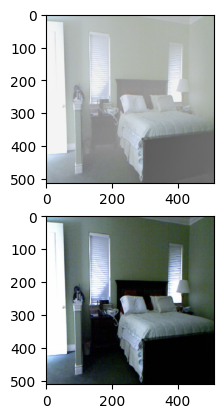

In [ ]:
batch=next(val_dataset)
x=batch[0][0]
y=batch[1][0]

plt.subplot(2,1,1)
plt.imshow(x)
plt.subplot(2,1,2)
plt.imshow(y)
print(np.shape(x))

In [ ]:
x=np.reshape(x,(1,512,512,3))
prdn=model.predict(x)
psnr=tf.image.psnr(
    y, prdn[0], 1, name=None
)

ssim=tf.image.ssim(
    y, prdn[0], 1,
)

1/1 [==============================] - 0s 409ms/step


In [ ]:
batch=next(val_dataset)
ssimt=[]
psnrt=[]
for i in range(len(batch)):
    x=batch[0][i]
    y=batch[1][i]
    x=np.reshape(x,(1,512,512,3))
    prdn=model.predict(x)[0]
    psnr=tf.image.psnr(
    y, prdn, 1, name=None)

    ssim=tf.image.ssim(
    y, prdn, 1)

    ssimt.append(ssim)
    psnrt.append(psnr)

print(np.mean(ssimt))
print(np.mean(psnrt))

1/1 [==============================] - 0s 148ms/step
0.6951444
14.459745
